<a href="https://www.kaggle.com/code/sidhanthprabhudesai/target-sales-exploration-with-sql?scriptVersionId=250220886" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/target/products.csv
/kaggle/input/target/geolocation.csv
/kaggle/input/target/order_items.csv
/kaggle/input/target/orders.csv
/kaggle/input/target/customers.csv
/kaggle/input/target/sellers.csv
/kaggle/input/target/payments.csv
/kaggle/input/target/order_reviews.csv


In [2]:
import sqlite3 as sql
import matplotlib.pyplot  as plt
import seaborn as sns

In [3]:
customers = pd.read_csv('/kaggle/input/target/customers.csv')
geolocation = pd.read_csv('/kaggle/input/target/geolocation.csv')
order_items = pd.read_csv('/kaggle/input/target/order_items.csv')
order_reviews = pd.read_csv('/kaggle/input/target/order_reviews.csv')
orders = pd.read_csv('/kaggle/input/target/orders.csv')
payments = pd.read_csv('/kaggle/input/target/payments.csv')
products = pd.read_csv('/kaggle/input/target/products.csv')
sellers = pd.read_csv('/kaggle/input/target/sellers.csv')

In [4]:
db= sql.connect("target.db")

In [5]:
customers.to_sql("customers",db,if_exists= "replace",index= False)
geolocation.to_sql("geolocation",db,if_exists= "replace",index= False)
order_items.to_sql("order_items",db,if_exists= "replace",index= False)
order_reviews.to_sql("order_reviews",db,if_exists= "replace",index= False)
orders.to_sql("orders",db,if_exists= "replace",index= False)
payments.to_sql("payments",db,if_exists= "replace",index= False)
products.to_sql("products",db,if_exists= "replace",index= False)
sellers.to_sql("sellers",db,if_exists= "replace",index= False)

3095

In [6]:
q1="""SELECT * FROM customers;"""
df1=pd.read_sql_query(q1,db)

Get the time range between which the orders were placed.

In [7]:
time_period = """select min(order_purchase_timestamp) as `First_order_date`,
max(order_purchase_timestamp) as `last_order_date`
from orders;"""
df_time_period=pd.read_sql_query(time_period,db)
print(df_time_period)

      First_order_date      last_order_date
0  2016-09-04 21:15:19  2018-10-17 17:30:18


Count the Cities & States of customers who ordered during the given period.

In [8]:
customercount = """select customer_city, customer_state,count(*) as Number_Of_Customers_in_Region
from `Customers`
Where customer_id in (select customer_id from`Orders`
where order_purchase_timestamp between (select min(order_purchase_timestamp) from
`Orders`
)and (select max(order_purchase_timestamp) from `Orders`))
group by customer_city, customer_state
order by Number_Of_Customers_in_Region desc;"""
df_customercount=pd.read_sql_query(customercount,db)
print(df_customercount)

        customer_city customer_state  Number_Of_Customers_in_Region
0           sao paulo             SP                          15540
1      rio de janeiro             RJ                           6882
2      belo horizonte             MG                           2773
3            brasilia             DF                           2131
4            curitiba             PR                           1521
...               ...            ...                            ...
4305  vitoria do jari             AP                              1
4306         vitorino             PR                              1
4307        vitorinos             MG                              1
4308           wagner             BA                              1
4309            xexeu             PE                              1

[4310 rows x 3 columns]


In-Depth exploration 

Is there a growing trend in the no. of orders placed over the past years?

In [9]:
growth_trend = """select strftime('%Y',order_purchase_timestamp) as Year_Of_Purchase,
count(order_id) as Total_Orders_Placed
from Orders
group by Year_Of_Purchase
order by Year_Of_Purchase asc"""
df_growth_trend=pd.read_sql_query(growth_trend,db)
print(df_growth_trend)

  Year_Of_Purchase  Total_Orders_Placed
0             2016                  329
1             2017                45101
2             2018                54011


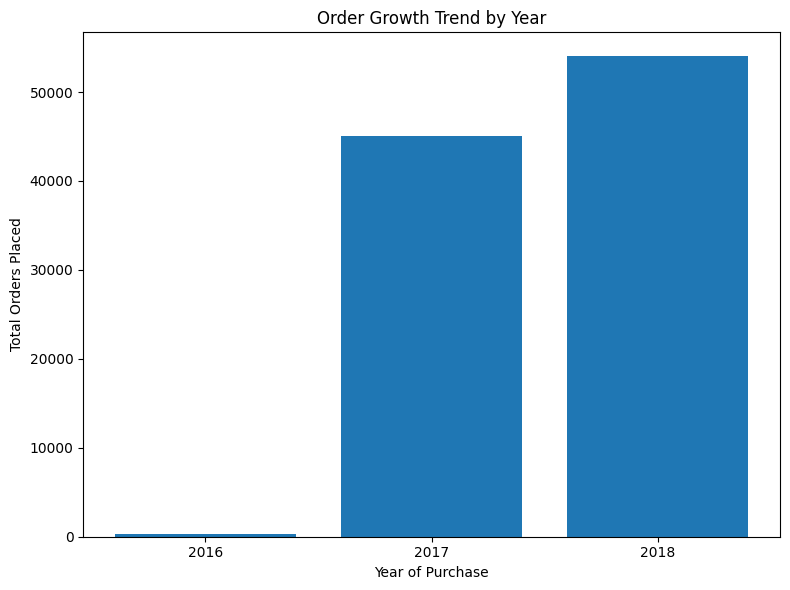

In [10]:
plt.figure(figsize=(8, 6))
plt.bar(df_growth_trend['Year_Of_Purchase'],df_growth_trend['Total_Orders_Placed'] )
plt.xlabel('Year of Purchase')
plt.ylabel('Total Orders Placed')
plt.title('Order Growth Trend by Year')

plt.tight_layout()

Can we see some kind of monthly seasonality in terms of the no. of orders being placed?

In [11]:
seasonal_trend="""select strftime('%m', order_purchase_timestamp) as Month_Of_Purchase,
count(order_id) as Total_Orders_Placed
from Orders
group by Month_Of_Purchase
order by Month_Of_Purchase asc"""
df_seasonal_trend=pd.read_sql_query(seasonal_trend,db)
print(df_seasonal_trend)

   Month_Of_Purchase  Total_Orders_Placed
0                 01                 8069
1                 02                 8508
2                 03                 9893
3                 04                 9343
4                 05                10573
5                 06                 9412
6                 07                10318
7                 08                10843
8                 09                 4305
9                 10                 4959
10                11                 7544
11                12                 5674


Text(0.5, 1.0, 'Order Growth Trend by month')

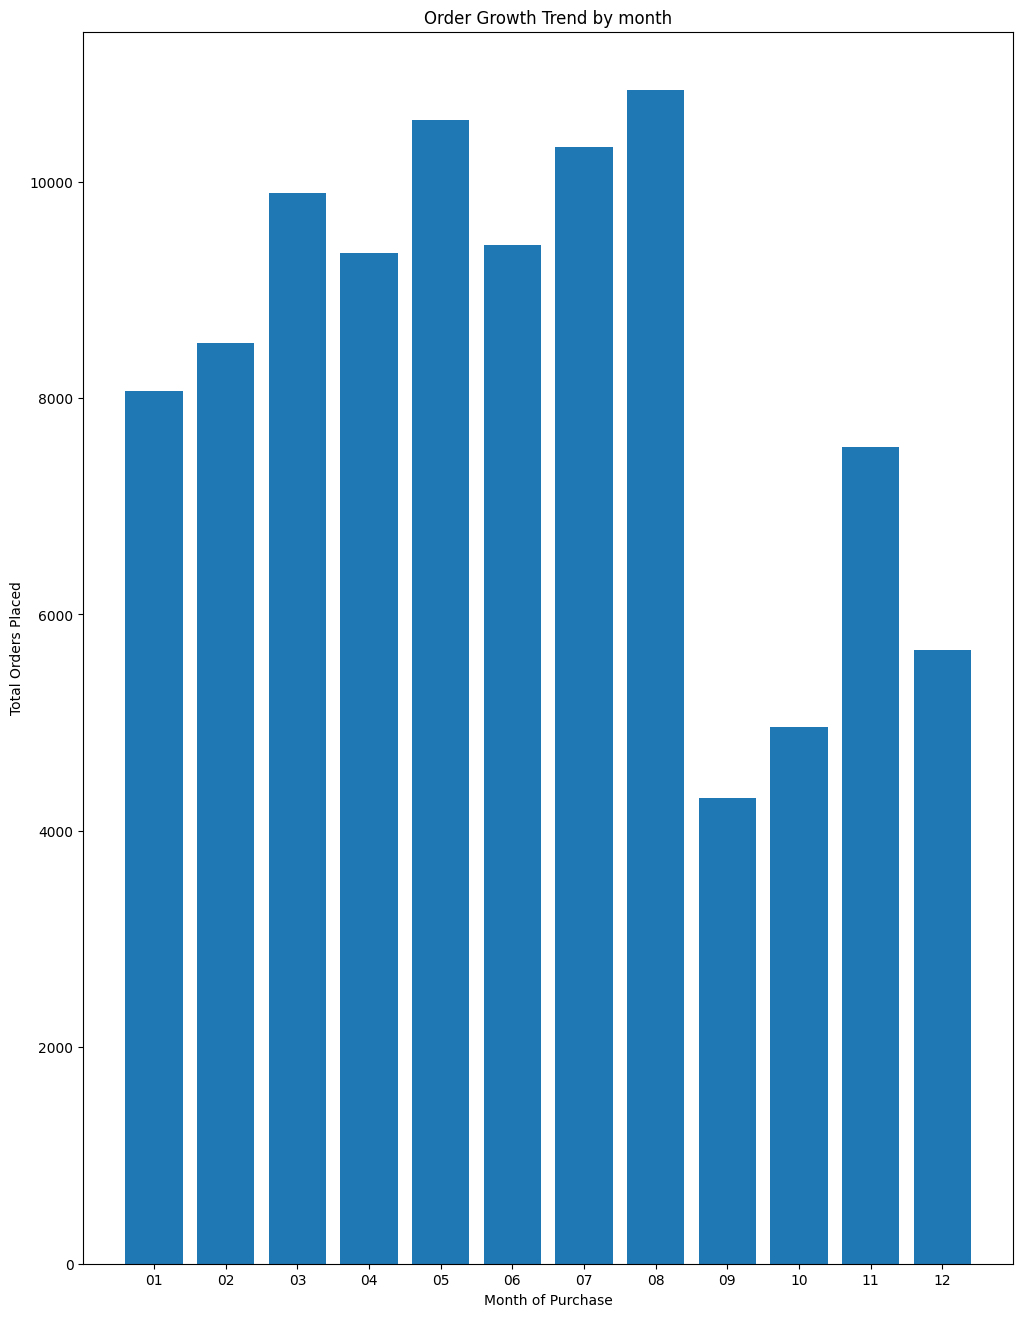

In [12]:
plt.figure(figsize=(12,16))
plt.bar(df_seasonal_trend['Month_Of_Purchase'], df_seasonal_trend['Total_Orders_Placed'])
plt.xlabel('Month of Purchase')
plt.ylabel('Total Orders Placed')
plt.title('Order Growth Trend by month')

During what time of the day, do the Brazilian customers mostly place their orders?
(Dawn, Morning, Afternoon or Night)

In [13]:
Day_trend_brazil = """SELECT
  CASE
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 0 AND 6 THEN 'Dawn'
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 7 AND 12 THEN 'Morning'
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 13 AND 18 THEN 'Afternoon'
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 19 AND 23 THEN 'Night'
  END AS time_Of_Purchase,
  COUNT(order_id) AS Total_Orders_Placed
FROM Orders
GROUP BY time_Of_Purchase
ORDER BY Total_Orders_Placed DESC;"""
df_Day_trend_brazil=pd.read_sql_query(Day_trend_brazil,db)
print(df_Day_trend_brazil)

  time_Of_Purchase  Total_Orders_Placed
0        Afternoon                38135
1            Night                28331
2          Morning                27733
3             Dawn                 5242


Text(0.5, 1.0, 'Order trend by time')

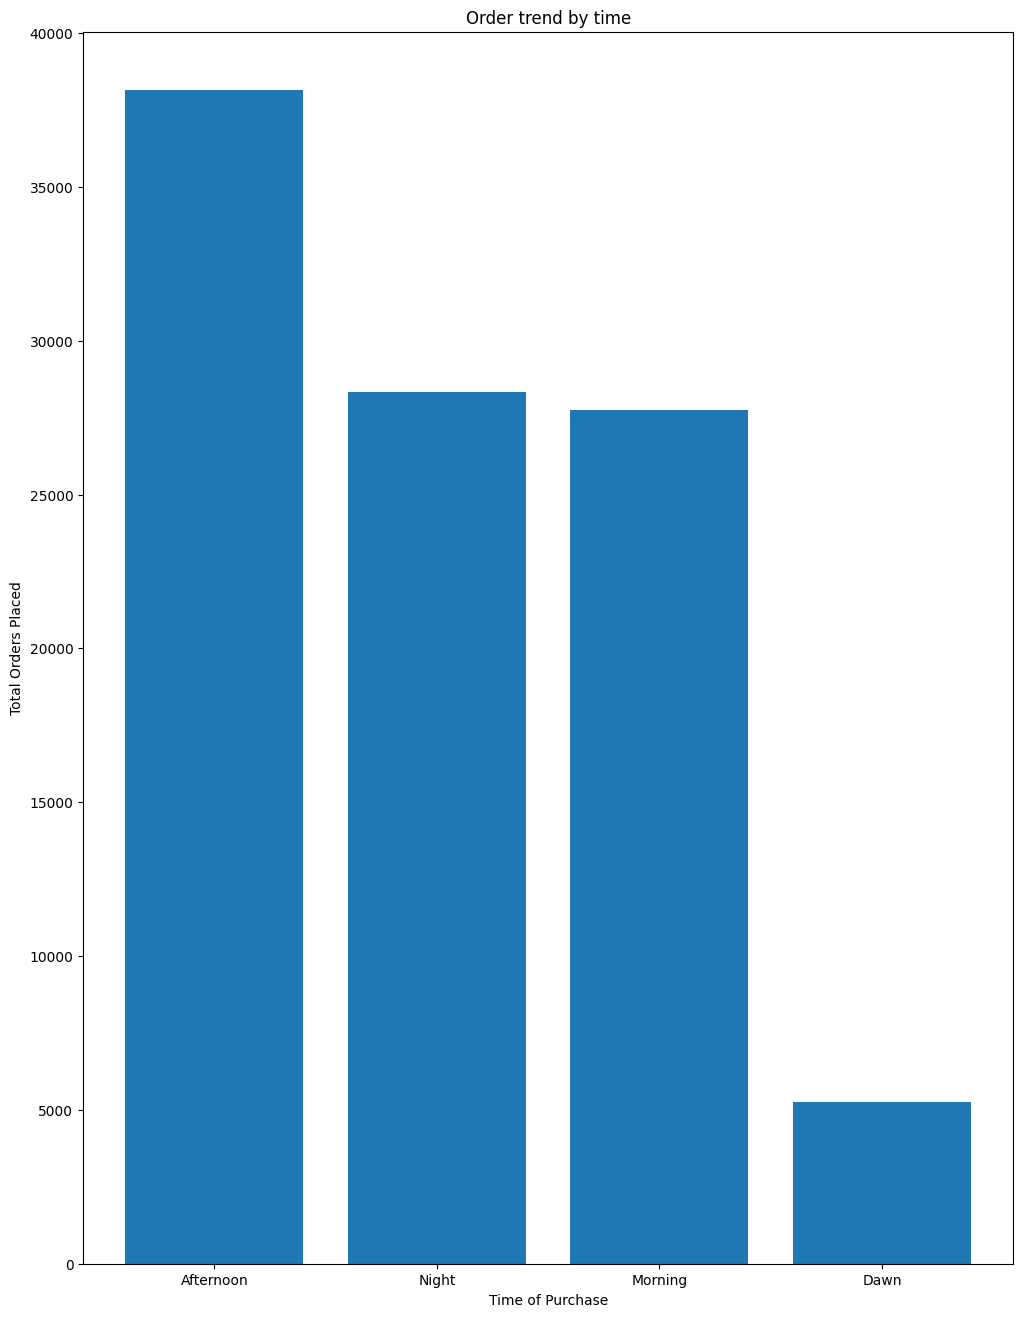

In [14]:
plt.figure(figsize=(12,16))
plt.bar(df_Day_trend_brazil['time_Of_Purchase'], df_Day_trend_brazil['Total_Orders_Placed'])
plt.xlabel('Time of Purchase')
plt.ylabel('Total Orders Placed')
plt.title('Order trend by time')

Evolution of E-commerce orders in the Brazil region

In [15]:
momthly_order_trnd_by_state = """SELECT
  CASE
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 0 AND 6 THEN 'Dawn'
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 7 AND 12 THEN 'Morning'
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 13 AND 18 THEN 'Afternoon'
    WHEN CAST(STRFTIME('%H', order_purchase_timestamp) AS INTEGER) BETWEEN 19 AND 23 THEN 'Night'
  END AS time_Of_Purchase,
  COUNT(order_id) AS Total_Orders_Placed
FROM Orders
GROUP BY time_Of_Purchase
ORDER BY Total_Orders_Placed DESC;
"""
df_momthly_order_trnd_by_state=pd.read_sql_query(momthly_order_trnd_by_state,db)
print(df_momthly_order_trnd_by_state)

  time_Of_Purchase  Total_Orders_Placed
0        Afternoon                38135
1            Night                28331
2          Morning                27733
3             Dawn                 5242


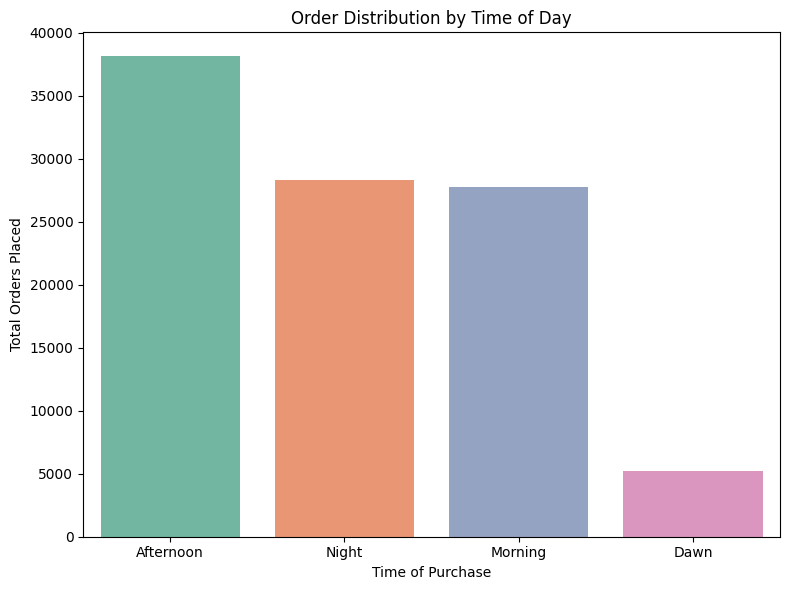

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x='time_Of_Purchase',
    y='Total_Orders_Placed',
    data=df_Day_trend_brazil,
    palette='Set2'
)
plt.title('Order Distribution by Time of Day')
plt.xlabel('Time of Purchase')
plt.ylabel('Total Orders Placed')
plt.tight_layout()
plt.show()

How are the customers distributed across all the states

In [17]:
cust_state_distribution ="""select customer_state, count (customer_id) as Customer_Count from
`Customers`
group by customer_state
order by Customer_Count desc"""
df_cust_state_distribution=pd.read_sql_query(cust_state_distribution,db)
print(df_cust_state_distribution)

   customer_state  Customer_Count
0              SP           41746
1              RJ           12852
2              MG           11635
3              RS            5466
4              PR            5045
5              SC            3637
6              BA            3380
7              DF            2140
8              ES            2033
9              GO            2020
10             PE            1652
11             CE            1336
12             PA             975
13             MT             907
14             MA             747
15             MS             715
16             PB             536
17             PI             495
18             RN             485
19             AL             413
20             SE             350
21             TO             280
22             RO             253
23             AM             148
24             AC              81
25             AP              68
26             RR              46


Impact on Economy: Analyse the money movement by e-commerce
by looking at order prices, freight and others.

In [18]:
percent_increase_inYear = """WITH year_date AS (
  SELECT
    CAST(STRFTIME('%m', order_purchase_timestamp) AS INTEGER) AS month,
    CAST(STRFTIME('%Y', order_purchase_timestamp) AS INTEGER) AS year,
    order_id
  FROM Orders
  WHERE 
    CAST(STRFTIME('%m', order_purchase_timestamp) AS INTEGER) BETWEEN 1 AND 8
    AND CAST(STRFTIME('%Y', order_purchase_timestamp) AS INTEGER) BETWEEN 2017 AND 2018
),
year_summary AS (
  SELECT 
    y.year,
    SUM(p.payment_value) AS Total_value
  FROM year_date y
  INNER JOIN payments p ON y.order_id = p.order_id
  GROUP BY y.year
  ORDER BY y.year ASC
)
SELECT 
  S.year, 
  S.Total_value AS cost_of_order,
  (S.Total_value - LAG(S.Total_value) OVER (ORDER BY S.year)) * 100.0 /
    NULLIF(LAG(S.Total_value) OVER (ORDER BY S.year), 0) AS percent_increase
FROM year_summary S
ORDER BY S.year ASC;
"""
df_percent_increase_inYear=pd.read_sql_query(percent_increase_inYear,db)
print(df_percent_increase_inYear)

   year  cost_of_order  percent_increase
0  2017     3669022.12               NaN
1  2018     8694733.84        136.976872


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Calculate the Total & Average value of order price for each state.

In [19]:
Total_and_avg_order_perState = """select
distinct C.customer_state,
sum (OI.price) over (partition by C.customer_state order by C.customer_state ) as
Total_cost,
round( avg (OI.price) over (partition by C.customer_state order by C.customer_state
), 2) as Avg_cost
from Orders o
inner join order_items OI
on o.order_id = OI.order_id
inner join Customers C
on C.customer_id = o.customer_id
order by Total_cost desc, Avg_cost desc;"""
df_Total_and_avg_order_perState=pd.read_sql_query(Total_and_avg_order_perState,db)
print(df_Total_and_avg_order_perState)

   customer_state    Total_cost  Avg_cost
0              SP  5.202955e+06    109.65
1              RJ  1.824093e+06    125.12
2              MG  1.585308e+06    120.75
3              RS  7.503040e+05    120.34
4              PR  6.830838e+05    119.00
5              SC  5.205533e+05    124.65
6              BA  5.113500e+05    134.60
7              DF  3.026039e+05    125.77
8              GO  2.945919e+05    126.27
9              ES  2.750373e+05    121.91
10             PE  2.627880e+05    145.51
11             CE  2.272547e+05    153.76
12             PA  1.789478e+05    165.69
13             MT  1.564535e+05    148.30
14             MA  1.196482e+05    145.20
15             MS  1.168126e+05    142.63
16             PB  1.152681e+05    191.48
17             PI  8.691408e+04    160.36
18             RN  8.303498e+04    156.97
19             AL  8.031481e+04    180.89
20             SE  5.892085e+04    153.04
21             TO  4.962174e+04    157.53
22             RO  4.614064e+04   

Calculate the Total & Average value of order freight for each state.

In [20]:
total_and_avg_frieght="""select
distinct C.customer_state,
round(sum (OI.freight_value) over (partition by C.customer_state order by
C.customer_state ),2) as Total_frieght_cost,
round( avg (OI.freight_value) over (partition by C.customer_state order by
C.customer_state ), 2) as Avg_frieght_cost
from Orders o
inner join order_items OI
on o.order_id = OI.order_id
inner join Customers C
on C.customer_id = o.customer_id
order by Total_frieght_cost desc, Avg_frieght_cost desc;"""
df_total_and_avg_frieght=pd.read_sql_query(total_and_avg_frieght,db)
print(df_total_and_avg_frieght)

   customer_state  Total_frieght_cost  Avg_frieght_cost
0              SP           718723.07             15.15
1              RJ           305589.31             20.96
2              MG           270853.46             20.63
3              RS           135522.74             21.74
4              PR           117851.68             20.53
5              BA           100156.68             26.36
6              SC            89660.26             21.47
7              PE            59449.66             32.92
8              GO            53114.98             22.77
9              DF            50625.50             21.04
10             ES            49764.60             22.06
11             CE            48351.59             32.71
12             PA            38699.30             35.83
13             MA            31523.77             38.26
14             MT            29715.43             28.17
15             PB            25719.73             42.72
16             PI            21218.20           

Analysis based on sales, freight and delivery time

We can calculate the delivery time and the difference between the estimated
& actual delivery date using the given formula:

In [21]:
diff_est_delivery = """SELECT 
  order_id, 
  CAST(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp) AS INTEGER) AS time_to_deliver,
  CAST(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_estimated_delivery_date) AS INTEGER) AS diff_estimated_delivery
FROM Orders
WHERE 
  order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL
  AND order_estimated_delivery_date IS NOT NULL
ORDER BY time_to_deliver DESC, diff_estimated_delivery DESC;"""
df_diff_est_delivery=pd.read_sql_query(diff_est_delivery,db)
print(df_diff_est_delivery)

                               order_id  time_to_deliver  \
0      ca07593549f1816d26a572e06dc1eab6              209   
1      1b3190b2dfa9d789e1f14c05b647a14a              208   
2      440d0d17af552815d15a9e41abe49359              195   
3      285ab9426d6982034523a855f55a885e              194   
4      0f4519c5f1c541ddec9f21b3bddd533a              194   
...                                 ...              ...   
96471  f349cdb62f69c3fae5c4d7d3f3a4a185                0   
96472  38c1e3d4ed6a13cd0cf612d4c09766e9                0   
96473  434cecee7d1a65fc65358a632b6f725f                0   
96474  bb5a519e352b45b714192a02ffe25681                0   
96475  8339b608be0d84fca9d8da68b58332c3                0   

       diff_estimated_delivery  
0                          181  
1                          188  
2                          165  
3                          166  
4                          161  
...                        ...  
96471                      -12  
96472          

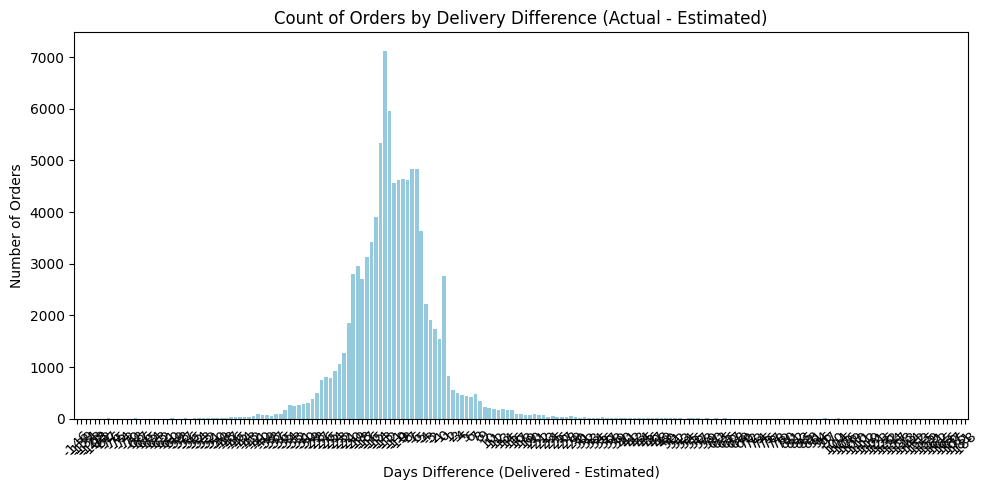

In [22]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_diff_est_delivery, x='diff_estimated_delivery', color='skyblue')

plt.title('Count of Orders by Delivery Difference (Actual - Estimated)')
plt.xlabel('Days Difference (Delivered - Estimated)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [23]:

Q1 = df_diff_est_delivery['diff_estimated_delivery'].quantile(0.25)
Q3 = df_diff_est_delivery['diff_estimated_delivery'].quantile(0.75)


IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")


IQR: 10.0
Lower bound: -31.0
Upper bound: 9.0


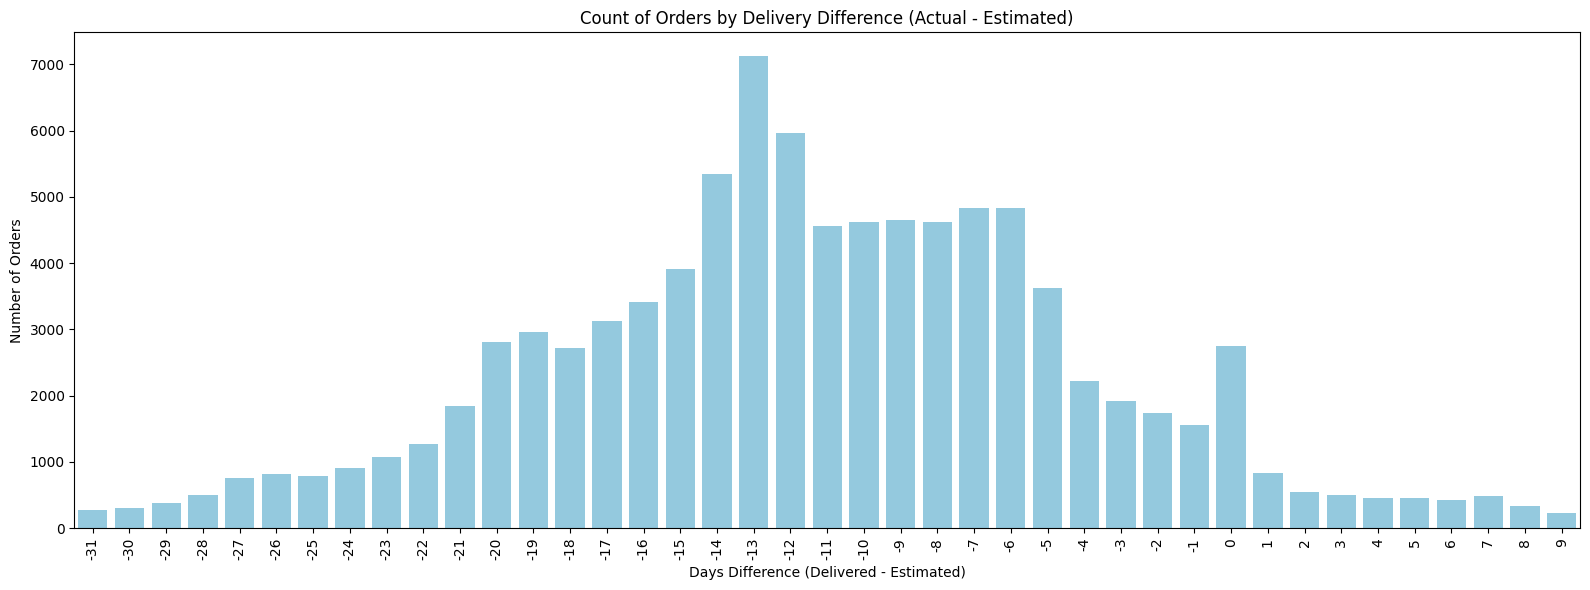

In [24]:
df_clipped = df_diff_est_delivery[
    df_diff_est_delivery['diff_estimated_delivery'].between(lower_bound, upper_bound)
]

plt.figure(figsize=(16, 6))
sns.countplot(data=df_clipped, x='diff_estimated_delivery', color='skyblue')

plt.title('Count of Orders by Delivery Difference (Actual - Estimated)')
plt.xlabel('Days Difference (Delivered - Estimated)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Find out the top 5 states with the highest & lowest average freight value

In [25]:
High_frieght_state = """select C.customer_state,
avg (OI.freight_value)as Highest_average_freight
from order_items OI
inner join Orders o on o.order_id = OI.order_id
inner join `Customers` C on C.customer_id = o.customer_id
group by C.customer_state
order by Highest_average_freight desc limit 5;"""
df_High_frieght_state=pd.read_sql_query(High_frieght_state,db)
print(df_High_frieght_state)

  customer_state  Highest_average_freight
0             RR                42.984423
1             PB                42.723804
2             RO                41.069712
3             AC                40.073370
4             PI                39.147970


In [26]:
Low_frieght_state = """select C.customer_state,
avg (OI.freight_value)as Lowest_average_freight
from order_items OI
inner join Orders o on o.order_id = OI.order_id
inner join `Customers` C on C.customer_id = o.customer_id
group by C.customer_state
order by Lowest_average_freight asc limit 5;"""
df_Low_frieght_state=pd.read_sql_query(High_frieght_state,db)
print(df_Low_frieght_state)

  customer_state  Highest_average_freight
0             RR                42.984423
1             PB                42.723804
2             RO                41.069712
3             AC                40.073370
4             PI                39.147970


Find out the top 5 states with the highest & lowest average delivery time.

In [27]:
Highest_delivery_time_state = """
SELECT 
  C.customer_state,
  ROUND(AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)), 2) AS highest_time_to_deliver
FROM order_items OI
INNER JOIN Orders o ON o.order_id = OI.order_id
INNER JOIN Customers C ON C.customer_id = o.customer_id
WHERE 
  order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL
GROUP BY C.customer_state
ORDER BY highest_time_to_deliver DESC
LIMIT 5;
"""

df_Highest_delivery_time_state = pd.read_sql_query(Highest_delivery_time_state, db)
print(df_Highest_delivery_time_state)

  customer_state  highest_time_to_deliver
0             RR                    28.23
1             AP                    28.21
2             AM                    26.39
3             AL                    24.49
4             PA                    23.75


In [28]:
Lowest_delivery_time_state = """
SELECT 
  C.customer_state,
  ROUND(AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)), 2) AS lowest_time_to_deliver
FROM order_items OI
INNER JOIN Orders o ON o.order_id = OI.order_id
INNER JOIN Customers C ON C.customer_id = o.customer_id
WHERE 
  order_delivered_customer_date IS NOT NULL
  AND order_purchase_timestamp IS NOT NULL
GROUP BY C.customer_state
ORDER BY lowest_time_to_deliver asc
LIMIT 5;
"""

df_Lowest_delivery_time_state = pd.read_sql_query(Lowest_delivery_time_state, db)
print(df_Lowest_delivery_time_state)

  customer_state  lowest_time_to_deliver
0             SP                    8.72
1             PR                   11.95
2             MG                   11.98
3             DF                   12.96
4             SC                   15.00


Analysis based on the payments:

In [29]:
payment_trend_by_month = """
SELECT 
  CAST(STRFTIME('%m', O.order_purchase_timestamp) AS INTEGER) AS Month,
  P.payment_type,
  COUNT(P.order_id) AS Number_of_Orders
FROM payments P
INNER JOIN Orders O ON O.order_id = P.order_id
WHERE O.order_purchase_timestamp IS NOT NULL
GROUP BY Month, P.payment_type
ORDER BY Month ASC;
"""

df_payment_trend_by_month = pd.read_sql_query(payment_trend_by_month, db)
print(df_payment_trend_by_month)


    Month payment_type  Number_of_Orders
0       1          UPI              1715
1       1  credit_card              6103
2       1   debit_card               118
3       1      voucher               477
4       2          UPI              1723
5       2  credit_card              6609
6       2   debit_card                82
7       2      voucher               424
8       3          UPI              1942
9       3  credit_card              7707
10      3   debit_card               109
11      3      voucher               591
12      4          UPI              1783
13      4  credit_card              7301
14      4   debit_card               124
15      4      voucher               572
16      5          UPI              2035
17      5  credit_card              8350
18      5   debit_card                81
19      5      voucher               613
20      6          UPI              1807
21      6  credit_card              7276
22      6   debit_card               209
23      6      v

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

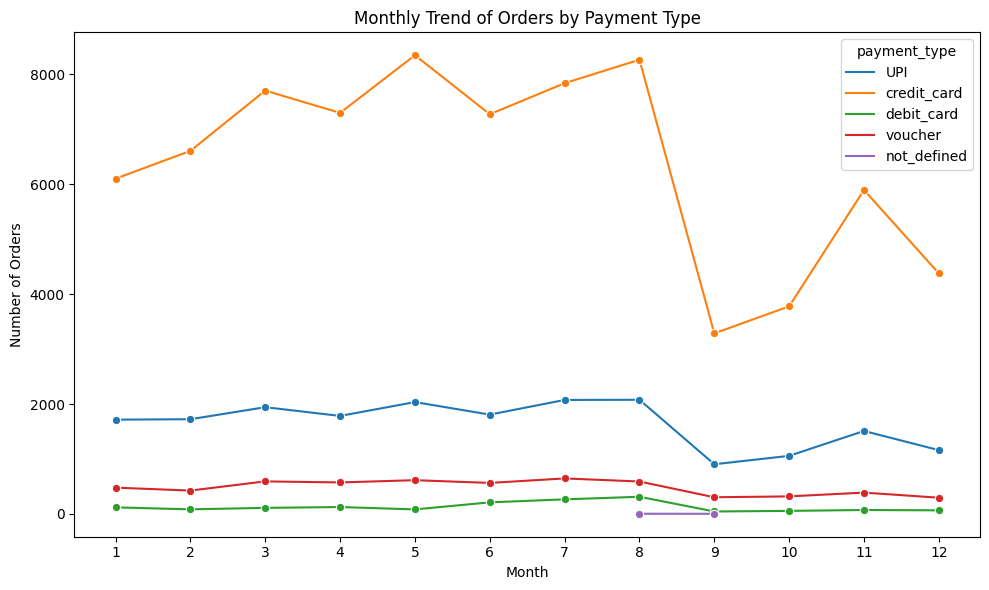

In [30]:

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_payment_trend_by_month, x='Month', y='Number_of_Orders', hue='payment_type', marker='o')
plt.title('Monthly Trend of Orders by Payment Type')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

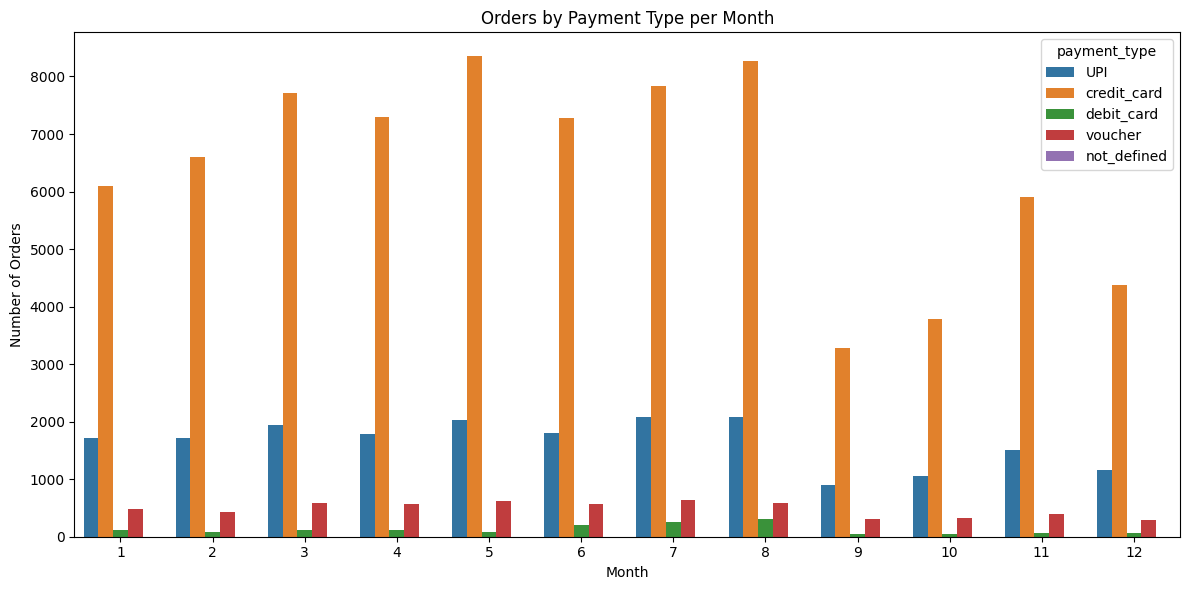

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_payment_trend_by_month, x='Month', y='Number_of_Orders', hue='payment_type')
plt.title('Orders by Payment Type per Month')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()